## mevpy package: tests and examples

In [6]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import mevpy as mev

font = {'family' : 'normal',
        'size'   : 12}

matplotlib.rc('font', **font)

In [ ]:
Test the GEV distribution related functions

Test functions for fitting - plotting the Weibull distribution

sample =  5.64893221684 74.7739460805
theo = 8.8607645424 167.914942129


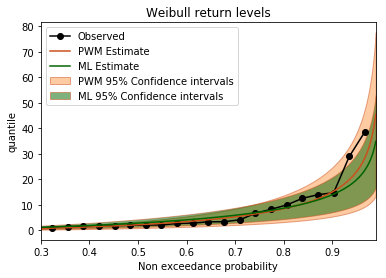

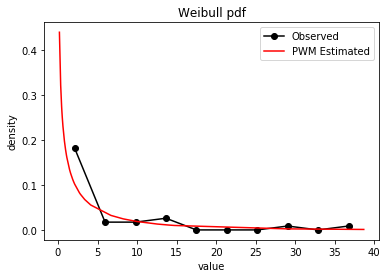

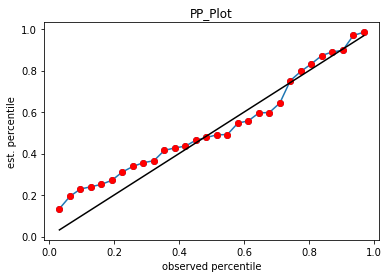

In [4]:
# Generate Weibull random variates
length = 30
C = 7
w = 0.7
sample = mev.wei_random_quant(length,C,w)
xi = np.sort(sample)
fi = np.arange(1,length + 1)/(length + 1)

# check mean and variance
musam  = np.mean(sample)
varsam = np.var(sample)
muteo, varteo = mev.wei_mean_variance(C,w)
print('sample = ', musam, varsam)
print('theo =', muteo, varteo)

# fit Weibull with various methods and produce bootstrap confidence Intervals
res_pwm = mev.wei_fit(sample, how = 'pwm', threshold = 0, std = True, std_how = 'boot', std_num = 1000)
res_ml = mev.wei_fit(sample, how = 'ml', threshold = 0, std = True, std_how = 'boot', std_num = 1000)
res_ls = mev.wei_fit(sample, how = 'ls', threshold = 0, std = True, std_how = 'boot', std_num = 1000)

# Fi = np.linspace(0.001,0.999,1000)
Fi = np.linspace(0.3,0.99,1000)
pq,pqu,pql = mev.wei_quant(Fi, res_pwm[0][1], res_pwm[0][2], ci = True, varcov = res_pwm[2])
mq,mqu,mql = mev.wei_quant(Fi, res_ml[0][1], res_ml[0][2], ci = True, varcov = res_ml[2])
lq,lqu,lql = mev.wei_quant(Fi, res_ls[0][1], res_ls[0][2], ci = True, varcov = res_ls[2])

fig = plt.figure()
ax = fig.add_subplot(111) # We'll explain the "111" later. Basically, 1 row and 1 column.
ax.set(title='Weibull return levels',
      ylabel='quantile', xlabel='Non exceedance probability')
ax.set_xlim([ np.min(Fi), np.max(Fi)])
# ax.set_ylim([-2, 8])
ax.plot(fi,xi, color='black', marker = 'o', label = 'Observed')
ax.plot(Fi,pq, color='#CC4F1B', label = 'PWM Estimate')
ax.fill_between(Fi, pql, pqu,
   alpha=0.5, edgecolor='#CC4F1B', facecolor='#FF9848', label = 'PWM 95% Confidence intervals')

ax.plot(Fi,mq, color='darkgreen', label = 'ML Estimate')
ax.fill_between(Fi, mql, mqu,
   alpha=0.5, edgecolor='#CC4F1B', facecolor='darkgreen', label = 'ML 95% Confidence intervals')
ax.legend(loc='upper left')
   
#ax.plot(Fi,lq, color='yellow', label = 'LS Estimate')
#ax.fill_between(Fi, lql, lqu,
#    alpha=0.5, edgecolor='yellow', facecolor='yellow', label = 'LS 95% Confidence intervals')
#ax.legend(loc='upper left')
   
# ax.set_yscale('log')
# ax.set_xscale('log')
ax.legend(loc='upper left')
plt.show()

# PDF
def emp_pdf(sample, nbins = 10, plot = False):
   '''
   compute and alternatively plot
   plot the empirical frequency density of a sample
   input: sample, nbins
   '''
   # alternatively give an array of bin centers
   # modify to extend it and add it to the package ?
   (counts, edges) = np.histogram(sample, nbins)
   dx = (edges[2]-edges[1])
   dens = counts/dx/np.sum(counts)
   binc = edges[:-1]+dx/2
   if plot == True:
       plt.plot(binc, dens,'ok')
       plt.show()
   return binc, dens

# PWM estimates
Chat = res_pwm[0][1]
what = res_pwm[0][2]

centers, emppdf = emp_pdf(sample, nbins = 10)
weipdf = mev.wei_pdf(xi, Chat, what)
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set(title='Weibull pdf',
      ylabel='density', xlabel='value')
ax.plot(centers,emppdf, color='black', marker = 'o', label = 'Observed')
ax.plot(xi,weipdf, color='red', label = 'PWM Estimated')
ax.legend(loc='upper right')
# ax.set_xscale('log')
# ax.set_yscale('log')
plt.show()

# Weibull CDF and survival function
fhi = mev.wei_cdf(xi, Chat, what)
shi = mev.wei_surv(xi, Chat, what)
fig = plt.figure()
plt.plot(fi, fhi,'-o')
plt.plot(fi, 1-shi,'or')
plt.plot(fi,fi,'k')
plt.xlabel('observed percentile')
plt.ylabel('est. percentile')
plt.title('PP_Plot')
plt.show()

2) TEST MEV FUNCTIONS 

/home/enri89/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


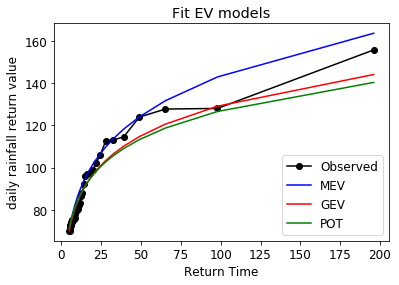

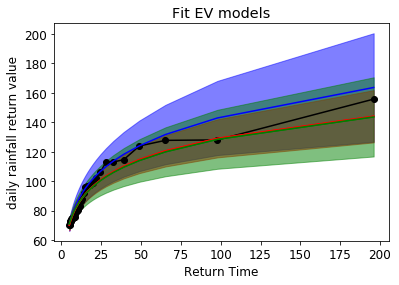

In [8]:
# read a time series of e.g. Daily Rainfall Values
# with headers PRCP = for daily rainfall data
# and DATE in format yyyymmdd or YEAR in format yyyy.

stats_dir  = 'data_stations_GRLmev/stations_csv'
statname = 'Milano.csv'
df = pd.read_csv(os.path.join(stats_dir, statname), header = 0) 

# compute years if not saved already
df['YEAR'] = np.rint(df.DATE/10000).astype(int)

# transform PRCP to millimiters
df.PRCP  = df.PRCP /10.0 # prcp in [mm]    

# remove years with more than 10% of missing data
nmin = 36
df, ny, ny_old  = mev.remove_missing_years(df, nmin)


# compute annual maxima and their frequency
Xi, Fi, TR = mev.tab_rain_max(df)

# annual maxima and yearly Weibull parameters
Xi, Fi, TR, NCW = mev.table_rainfall_maxima(df, how = 'pwm', thresh= 0 )

# fit Extreme Value Models
TR_val, XI_val, Fi_val, QM, QG, QP, FhM, FhG, FhP = mev.fit_EV_models(
                  df, tr_min = 5, ws = 1, GEV_how = 'lmom', MEV_how = 'pwm', 
                MEV_thresh = 0, POT_way = 'ea', POT_val = 1, POT_how = 'ml')

# plot quantiles
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set(title='Fit EV models',
      ylabel='daily rainfall return value', xlabel='Return Time')
ax.plot(TR_val, XI_val, color='black', marker = 'o', label = 'Observed')
ax.plot(TR_val, QM, color='blue', label = 'MEV')
ax.plot(TR_val, QG, color='red', label = 'GEV')
ax.plot(TR_val, QP, color='green', label = 'POT')
ax.legend(loc='lower right')
# ax.set_xscale('log')
# ax.set_yscale('log')
plt.show()

# with confidence intervals
TR_val, XI_val, Fi_val, QM, QG, QP, \
    QuM, QuG, QuP, QlM, QlG, QlP, FhM, FhG, FhP  =  \
   mev.fit_EV_models(df, tr_min = 5, ws = 1, GEV_how = 'lmom', MEV_how = 'pwm', \
    MEV_thresh = 0, POT_way = 'ea', POT_val = 3, POT_how = 'ml', \
       ci = True, ntimes = 10, std_how_MEV= 'boot', std_how_GEV = 'hess', std_how_POT = 'hess')

# plot results
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set(title='Fit EV models',
      ylabel='daily rainfall return value', xlabel='Return Time')
ax.plot(TR_val, XI_val, color='black', marker = 'o', label = 'Observed')
ax.plot(TR_val, QM, color='blue', label = 'MEV')
ax.plot(TR_val, QG, color='red', label = 'GEV')
ax.plot(TR_val, QP, color='green', label = 'POT')

ax.fill_between(TR_val, QlM, QuM,
   alpha = 0.5, edgecolor='blue', facecolor='blue', label = 'MEV 95% Confidence intervals')


ax.fill_between(TR_val, QlG, QuG,
   alpha = 0.5, edgecolor='red', facecolor='red', label = 'GEV 95% Confidence intervals')


ax.fill_between(TR_val, QlP, QuP,
   alpha = 0.5, edgecolor='green', facecolor='green', label = 'POT 95% Confidence intervals')

ax.plot(TR_val, QG, color='red', label = 'GEV')
ax.plot(TR_val, QP, color='green', label = 'POT')
# ax.legend(loc='lower right')
# ax.set_xscale('log')
# ax.set_yscale('log')
plt.show()



TEST CROSS VALIDATION

Sliding window analysis

slideover _ window =  0 of 166
slideover _ window =  1 of 166
slideover _ window =  2 of 166
slideover _ window =  3 of 166
slideover _ window =  4 of 166
slideover _ window =  5 of 166
slideover _ window =  6 of 166
slideover _ window =  7 of 166
slideover _ window =  8 of 166
slideover _ window =  9 of 166
slideover _ window =  10 of 166
slideover _ window =  11 of 166
slideover _ window =  12 of 166
slideover _ window =  13 of 166
slideover _ window =  14 of 166
slideover _ window =  15 of 166
slideover _ window =  16 of 166
slideover _ window =  17 of 166
slideover _ window =  18 of 166
slideover _ window =  19 of 166
slideover _ window =  20 of 166
slideover _ window =  21 of 166
slideover _ window =  22 of 166
slideover _ window =  23 of 166
slideover _ window =  24 of 166
slideover _ window =  25 of 166
slideover _ window =  26 of 166
slideover _ window =  27 of 166
slideover _ window =  28 of 166
slideover _ window =  29 of 166
slideover _ window =  30 of 166
slideover _ window

/home/enri89/Dropbox/py_rainfall/mevpy/gev_fun.py:576: RuntimeWarning: invalid value encountered in sqrt
  parstd = np.sqrt( np.diag(varcov) )
/home/enri89/Dropbox/py_rainfall/mevpy/gev_fun.py:377: RuntimeWarning: invalid value encountered in sqrt
  parstd = np.sqrt(np.diag(varcov))


slideover _ window =  143 of 166
slideover _ window =  144 of 166
slideover _ window =  145 of 166
slideover _ window =  146 of 166
slideover _ window =  147 of 166
slideover _ window =  148 of 166
slideover _ window =  149 of 166
slideover _ window =  150 of 166
slideover _ window =  151 of 166
slideover _ window =  152 of 166
slideover _ window =  153 of 166
slideover _ window =  154 of 166
slideover _ window =  155 of 166
slideover _ window =  156 of 166
slideover _ window =  157 of 166
slideover _ window =  158 of 166
slideover _ window =  159 of 166
slideover _ window =  160 of 166
slideover _ window =  161 of 166
slideover _ window =  162 of 166
slideover _ window =  163 of 166
slideover _ window =  164 of 166
slideover _ window =  165 of 166


/home/enri89/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


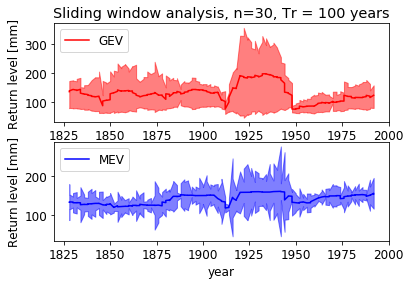

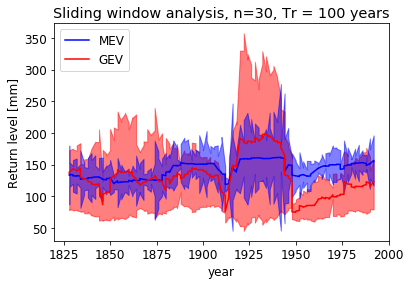

In [11]:
central_year, mq, mqu, mql, gq, gqu, gql, pq, pqu, pql, fig1, fig2 = mev.slideover(
                   df, winsize = 30, Tr = 100, ci = True, display = True, ntimes = 3)
# fig1.savefig('output_GRL/slideover/slideover_1.jpg', format='jpg', dpi = 300)
# fig2.savefig('output_GRL/slideover/slideover_2.jpg', format='jpg', dpi = 300)